In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

We begin by importing the following three data sets.

In [3]:
df_strikes = pd.read_csv("my_data/strikes_2000_2019.csv")
df_flights = pd.read_csv("my_data/schedule_T3.csv")
df_financial = pd.read_csv("my_data/schedule_P52.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,77,86,96,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Each row of df_strikes corresponds a report to the FAA of an aircraft wildlife strike.

The rows of df_flights contain flight statistics for a given year, quarter, US airport, and airline.
In particular, we want to use the data on the number of departing domestic and international flights in each row.

Each row of the dataframe df_financial is determined by a year, quarter, world region, airline, and aircraft type.
The rows record information about the operating expenses of that particular aircraft type for that particular airline and quarter. We will in particular be interested in the total maintenance costs.

# Flight Counts

We begin with the flights dataframe. The only information we are interested in extracting from this database is the number of flight departures for each airline in each quarter of each year.

We begin by restricting to the years we care about.

In [4]:
flight_counts = df_flights.copy().loc[(df_flights.YEAR <= 2019)&(df_flights.YEAR >= 2000)]

We want each row to correspond to a particular year, quarter, and airline, so we make "buckets" corresponding to these variables and calculate the number of departure flights in each bucket.

In [5]:
flight_row_id = ['YEAR', 'QUARTER', 'UNIQUE_CARRIER', 'UNIQUE_CARRIER_NAME']

# The variable 'REV_ACRFT_DEP_PERF_510' stores the number of departing flights
flight_counts = flight_counts.groupby(flight_row_id)['REV_ACRFT_DEP_PERF_510'].sum().reset_index()

In [6]:
flight_counts.sample(5)

,YEAR,QUARTER,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,REV_ACRFT_DEP_PERF_510
2565,2005,3,FE,Primaris Airlines Inc.,122.0
5244,2010,2,VI,Vieques Air Link Inc.,1909.0
7177,2014,2,G4,Allegiant Air,14134.0
2851,2006,1,FRA,Freedom Air,3712.0
748,2002,2,OH (1),Comair Inc.,69155.0


Let's rename the columns.

In [7]:
flight_counts.columns = ['YEAR', 'QUARTER', 'ICAO', 'AIRLINE', 'FLIGHTS']

Let's add a DATE column whose entries are the first day of each quarter. This will make graphing against time easier

In [8]:
# This function eats a row of a dataframe with 'YEAR' and 'QUARTER' columns and splits out the date of the
# first day of the quarter as a Pandas timestamp.
YQ_to_YMD = lambda x: pd.Timestamp(x.YEAR,x.QUARTER*3-2,1)

In [9]:
flight_counts.insert(loc=0, column='DATE', value=flight_counts.apply(YQ_to_YMD, axis=1))

In [10]:
flight_counts.head()

,DATE,YEAR,QUARTER,ICAO,AIRLINE,FLIGHTS
0,2000-01-01,2000,1,1I,Sky Trek International Airlines,612.0
1,2000-01-01,2000,1,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,3021.0
2,2000-01-01,2000,1,5X,United Parcel Service,29591.0
3,2000-01-01,2000,1,5Y,Atlas Air Inc.,193.0
4,2000-01-01,2000,1,8C,Air Transport International,2870.0


# Wildlife Strikes

Moving on to the strikes dataframe, we will count the number of entries in each quarter for each airline.

For our purposes, we only need the following three columns.

In [61]:
strike_variables = ['INCIDENT_DATE ', 'OPERATOR_ID', 'OPERATOR'] #, 'DAMAGE', 'COST_REPAIRS']

strikes = df_strikes.copy()[strike_variables]

In [62]:
strikes.sample(10)

,INCIDENT_DATE,OPERATOR_ID,OPERATOR
70413,11/25/15,ASQ,EXPRESSJET AIRLINES
27916,8/4/04,QXE,HORIZON AIR
5539,7/10/00,UAL,UNITED AIRLINES
150813,10/17/16,UNK,UNKNOWN
94767,7/22/12,UNK,UNKNOWN
25930,10/2/04,UAL,UNITED AIRLINES
67528,9/15/09,SKW,SKYWEST AIRLINES
38735,10/25/05,BUS,BUSINESS
118560,7/24/14,UNK,UNKNOWN
177648,10/17/18,AAL,AMERICAN AIRLINES


As the above sample makes clear, the airline is unknown for a lot of the recorded strikes. Let's remove these entries.

In [63]:
strikes = strikes.loc[strikes.OPERATOR_ID != 'UNK']

Let's also rename the OPERATOR_ID column.

In [64]:
strikes.columns = ['INCIDENT_DATE', 'IATA', 'OPERATOR']

We need replace the incident dates with Pandas timestamps. The dataframe is already limited to the correct time period, so we won't need to narrow our dates.

In [66]:
# This takes about a minute to run on my computer
strikes.INCIDENT_DATE = strikes.INCIDENT_DATE.apply(pd.Timestamp)

We create a new 'DATE' column which converts each incident date to the first day of the quarter.

In [67]:
quarter_time = lambda x: pd.Timestamp(x.year, x.quarter*3-2, 1)

strikes.insert(loc=0, column='DATE', value=strikes.INCIDENT_DATE.apply(quarter_time))

In [68]:
strikes.sample(5)

,DATE,INCIDENT_DATE,IATA,OPERATOR
137582,2015-10-01,2015-10-04,AAL,AMERICAN AIRLINES
58674,2008-10-01,2008-10-08,BUS,BUSINESS
152932,2017-01-01,2017-01-08,BUS,BUSINESS
196503,2019-07-01,2019-07-19,AAL,AMERICAN AIRLINES
172727,2018-07-01,2018-08-27,AAL,AMERICAN AIRLINES


We want to count the number of entries in each quarter for each airline. We add a column of ones to help with this.

In [69]:
strikes['COUNT'] = 1

In [70]:
strikes = strikes.groupby(['DATE', 'IATA', 'OPERATOR'])['COUNT'].count().reset_index()

In [71]:
strikes.head()

,DATE,IATA,OPERATOR,COUNT
0,2000-01-01,1AAH,ALOHA AIRLINES,3
1,2000-01-01,1ASQ,ATLANTIC SOUTHEAST,1
2,2000-01-01,1AWE,AMERICA WEST AIRLINES,17
3,2000-01-01,AAL,AMERICAN AIRLINES,49
4,2000-01-01,ABX,ABX AIR,11


# Merging Dataframes

Now we will merge the strikes and flight_count dataframes.

We begin by writing lists of the ICAO and IATA codes of the airlines we care about. We will create a dictionary to translate between the two codes.

In [89]:
IATA = ['UPS', 'AAL', 'ASA', 'JBU', 'DAL', 'FFT', 'FDX', 'AAY', 'NKS', 'UAL', 'SWA']
ICAO = ['5X', 'AA', 'AS', 'B6', 'DL', 'F9', 'FX', 'G4', 'NK', 'UA', 'WN']

In [90]:
AL_ID = {ICAO[i]: IATA[i] for i in range(len(IATA))}

Let's restrict the strikes and flight_count data frames to theses airlines.

In [101]:
flight_counts_re = flight_counts[flight_counts.ICAO.isin(ICAO)]

In [102]:
strikes_re = strikes[strikes.IATA.isin(IATA)]

To help us merge these dataframes, we will add an IATA code column to the flight_counts_re dataframe, using our dictionary to convert ICAO codes to IATA codes.

In [105]:
flight_counts_re.insert(loc=4, column='IATA', value=flight_counts_re.ICAO.apply(lambda x: AL_ID[x]))

We will also drop the extra columns from our datasets

In [106]:
flight_counts_re = flight_counts_re.drop(columns=['YEAR', 'QUARTER'])
strikes_re = strikes_re.drop(columns=['OPERATOR'])

Now we're ready to perform the merge.

In [107]:
strikes_index = pd.merge_ordered(flight_counts_re, strikes_re, on=['DATE', 'IATA'])

In [108]:
strikes_index.head(10)

,DATE,ICAO,IATA,AIRLINE,FLIGHTS,COUNT
0,2000-01-01,AA,AAL,American Airlines Inc.,193165.0,49.0
1,2000-01-01,G4,AAY,Allegiant Air,836.0,NaN
2,2000-01-01,AS,ASA,Alaska Airlines Inc.,38854.0,5.0
3,2000-01-01,DL,DAL,Delta Air Lines Inc.,229186.0,43.0
4,2000-01-01,FX,FDX,Federal Express Corporation,68570.0,14.0
5,2000-01-01,F9,FFT,Frontier Airlines Inc.,8669.0,NaN
6,2000-01-01,B6,JBU,JetBlue Airways,621.0,1.0
7,2000-01-01,NK,NKS,Spirit Air Lines,7575.0,1.0
8,2000-01-01,WN,SWA,Southwest Airlines Co.,218928.0,26.0
9,2000-01-01,UA,UAL,United Air Lines Inc.,192990.0,141.0


NaN values show up in the table because some airlines did not have any reported strikes in the specified quarter. Let's replace these values with 0's.

In [109]:
strikes_index.COUNT = strikes_index.COUNT.fillna(0)

It remains to calculate a wildlife strike index which scales the strike count by the number of flights.

In [110]:
strikes_index['STRIKE_INDEX'] = np.round(strikes_index.COUNT*10000/strikes_index.FLIGHTS, 2)

Let's graph the STRIKE_INDEX for various airlines.

In [113]:
def plot(iata_code):
    data = strikes_index[strikes_index.IATA==iata_code]
    plt.plot(data.DATE, data.STRIKE_INDEX, label=data.AIRLINE.iloc[0])

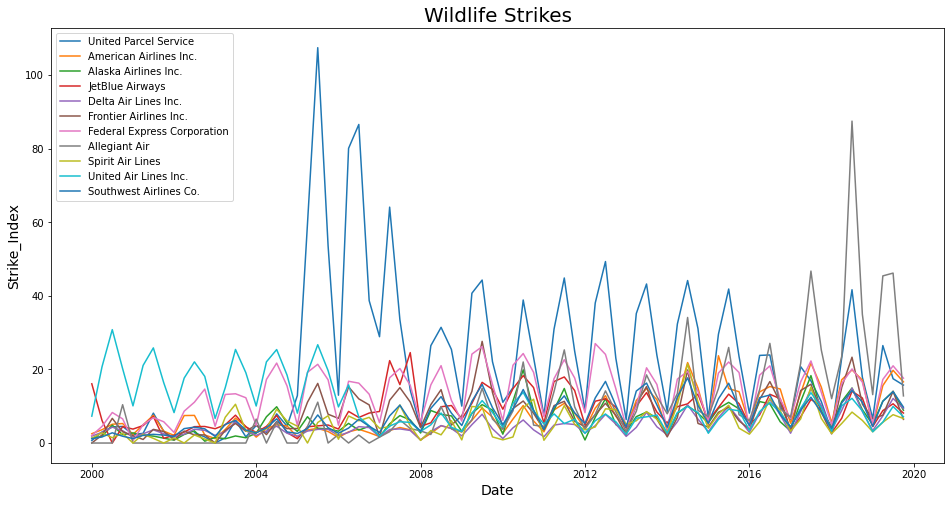

In [114]:
plt.figure(figsize=(16,8))

for airline in IATA:
    plot(airline)

plt.xlabel("Date", fontsize = 14)
plt.ylabel("Strike_Index", fontsize = 14)
plt.title("Wildlife Strikes", fontsize = 20)

plt.legend(fontsize=14)
plt.legend()

plt.show()

The data looks seasonal, but with only one peak per year rather than two.